In [14]:
%matplotlib inline 

import numpy as np
import h5py
import matplotlib.pyplot as plt

import sscCdi, sscCdiApps
sscCdi.__version__, sscCdiApps.__version__

('0.14.0', '0.0.9')

Object pixel = 1e-07 m
Probe shape = (2048, 2048)
Size of the array: 0.125 GB
Object shape = (2266, 2276)
Data shape = (16, 2048, 2048)
Positions shape = (16, 2)


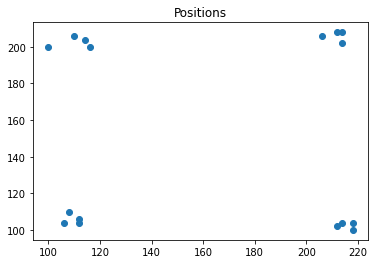

In [15]:
with h5py.File('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/ptycho_fresnel/Ptycho-id16-NFP/ID16_Siemens_YuriFormat.h5','r') as file:
    DPs = file['DPs'][()]
    positions = file['positions'][()].T
    energy = file['energy'][()]
    wavelength = file['wavelength'][()]
    pixel_size_detector = file['effective_pixel_detector'][()] 
    detector_distance = file['effective_detector_distance'][()]
    z1 = file['z1'][()]
    z2 = file['z2'][()]
    dark = file['dark'][()]
    
c_speed = 299792458        # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]
n_pixels = 2048

magnification = (z1+z2)/z1

inputs = {
"n_cpus": 32, # cpu cores
"energy": energy, #keV
"detector_distance": z2/magnification, # meter
"distance": z2/magnification, # meter
"detector_pixel_size": pixel_size_detector,
"source_distance": 0, # should be 0 if parallel beam
}


# inputs["detector_distance"] = z2
# inputs["distance"] = z2
# inputs["detector_pixel_size"] = pixel_size_detector*magnification
# inputs["source_distance"] = z1


wavelength = c_speed * planck / inputs["energy"]
inputs["wavelength"] = wavelength
inputs['object_pixel'] = inputs["detector_pixel_size"]
print(f'Object pixel = {inputs["object_pixel"]} m')
inputs['iterations'] = 10
inputs["fresnel_regime"] = True
inputs["probe_support"] = None
inputs["incoherent_modes"] = 1
inputs['beta'] = 0.9 # RAAR
inputs['epsilon'] = 0.01 # RAAR; small value to add to probe/object update denominator

probe = np.ones_like(DPs[0])
print(f'Probe shape = {probe.shape}')

empty = dark.mean(0)

inputs["object_padding"] = 100
positions = sscCdiApps.convert_probe_mogno_positions_meters_to_pixels(positions.copy(),inputs["object_pixel"],inputs["object_padding"])

fig, ax = plt.subplots()
ax.plot(positions[:,0],positions[:,1],'o')
ax.set_title('Positions')

size_in_bytes = DPs.nbytes # Get the size of the array in bytes
size_in_gb = size_in_bytes / (1024**3) # Convert the size to gigabytes
print("Size of the array:", size_in_gb, "GB")

padding = 10
inputs["object_shape"] = sscCdi.set_object_shape(padding, DPs.shape, positions)
inputs["object_shape"] = (inputs["object_shape"][1],inputs["object_shape"][0])
print(f'Object shape = {inputs["object_shape"]}')

print(f'Data shape = {DPs.shape}')
print(f'Positions shape = {positions.shape}')

(2048, 2048)

Data shape: (16, 2048, 2048)
Estimated size for 16 DPs of type float32: 0.27 GBs
Detector pixel size = 0.10 um
Energy = 33.35 keV
Wavelength = 0.037 nm


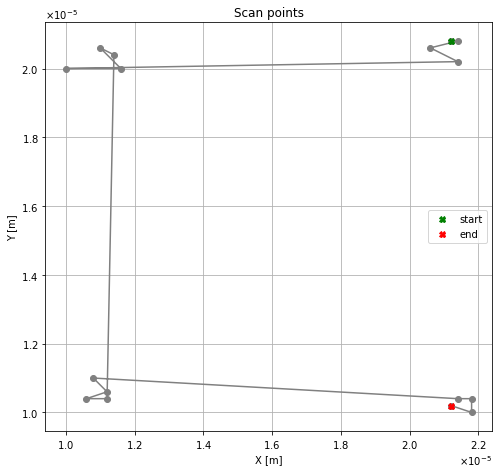

Creating output hdf5 file...
Plotting initial guesses...


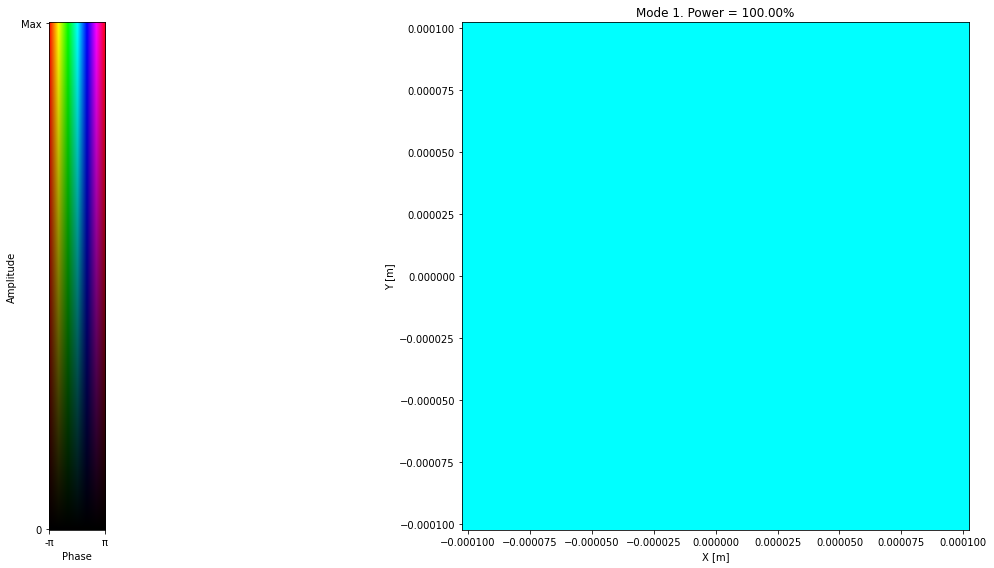

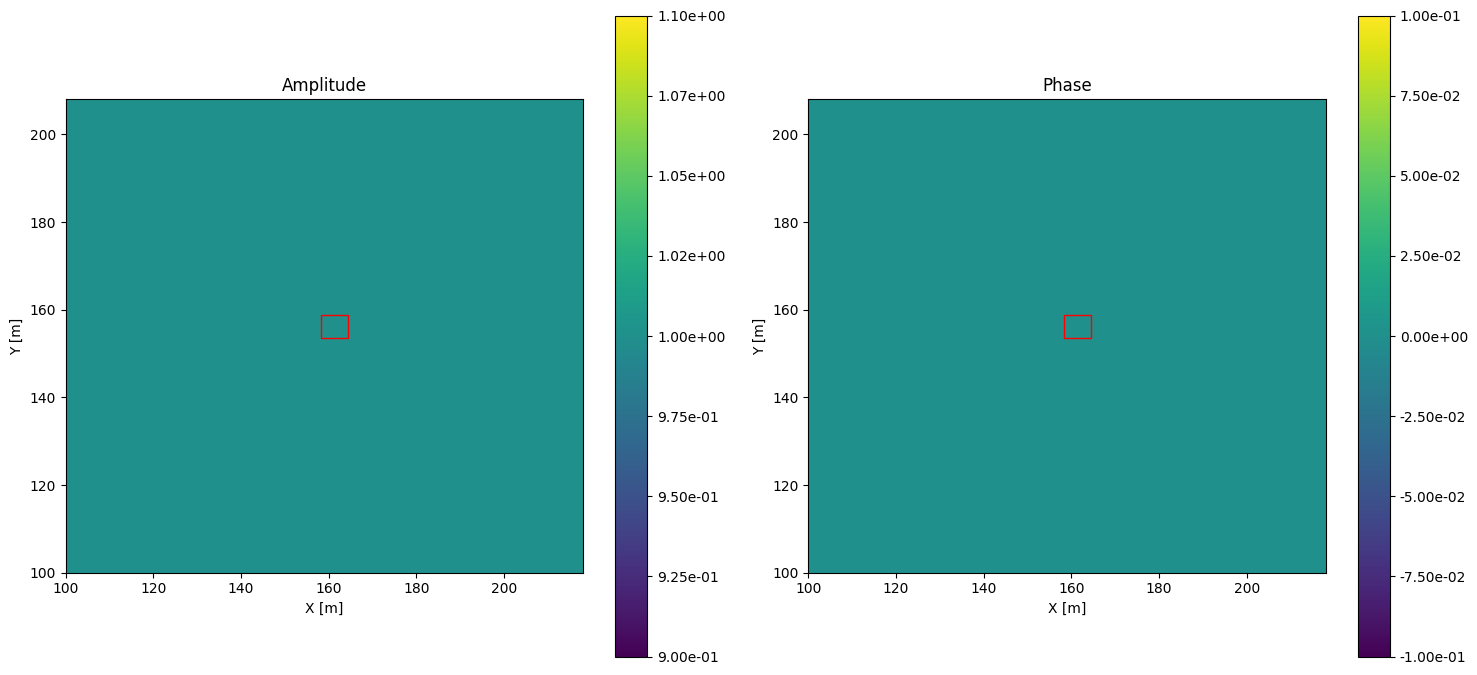

Setting probe support...


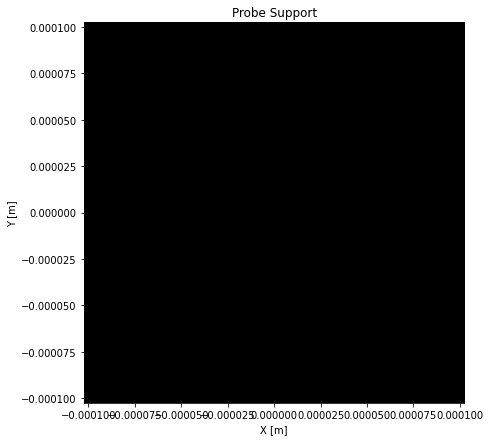

Distance between sample and focus: 0.0mm. Corresponding Fresnel number: 0
Total datapack size: 0.38 GBs
Starting ptychography... using 1 GPUs [0] and 32 CPUs
Calling 10 iterations of RAAR algorithm...
Using CuPy (GPU)
Transfering data to GPU...
Object shape: (1, 2266, 2276)
Probe shape: (1, 2048, 2048)
Diffraction patterns shape: (16, 2048, 2048)
Wavefronts shape: (16, 1, 2048, 2048)
Positions shape: (16, 2)
	Iteration 10/10 	 Errors: R-factor=4.21e-01; MSE=7.04e+00; Poisson LLK=2.66e+02

Plotting final object and probe...


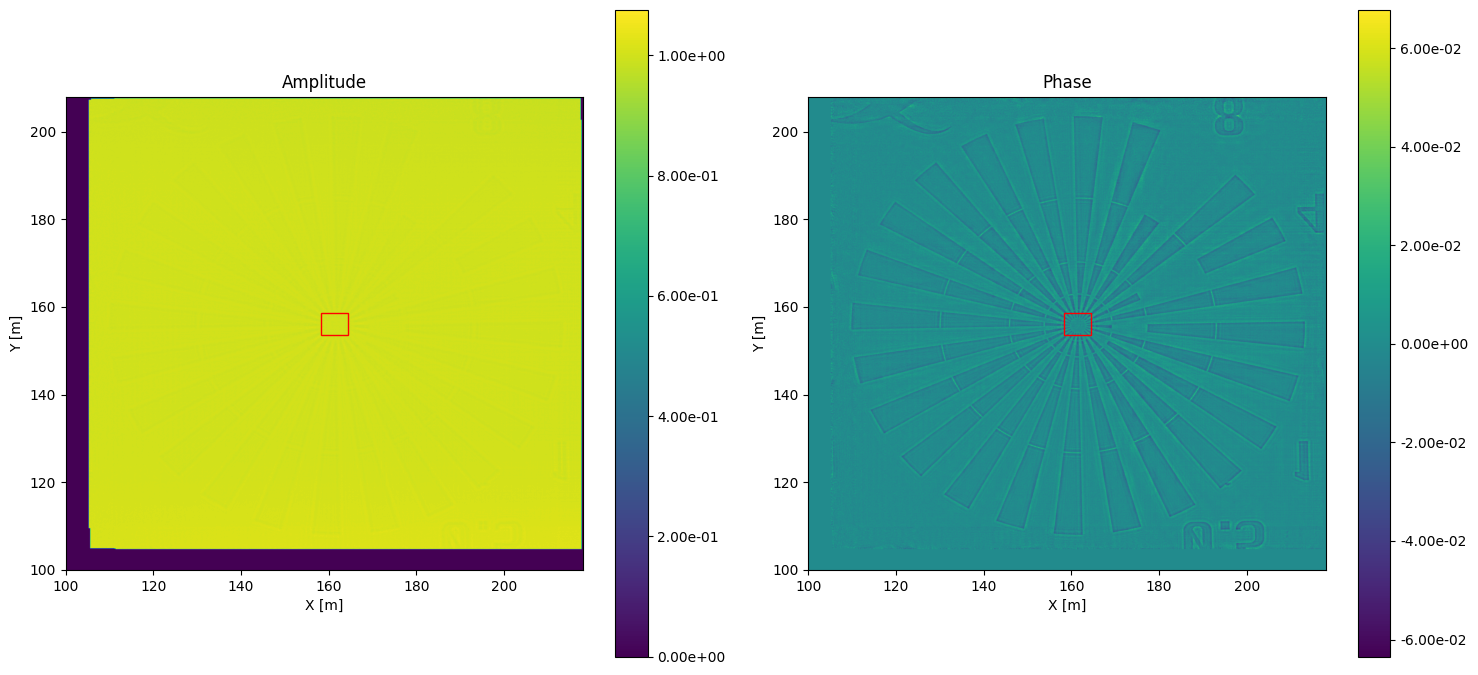

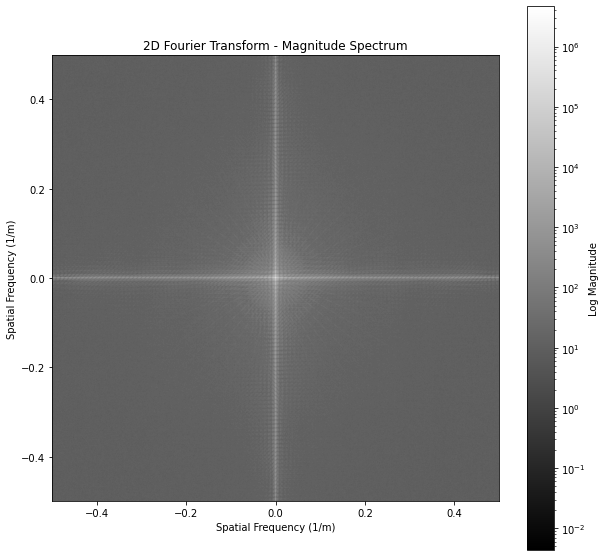

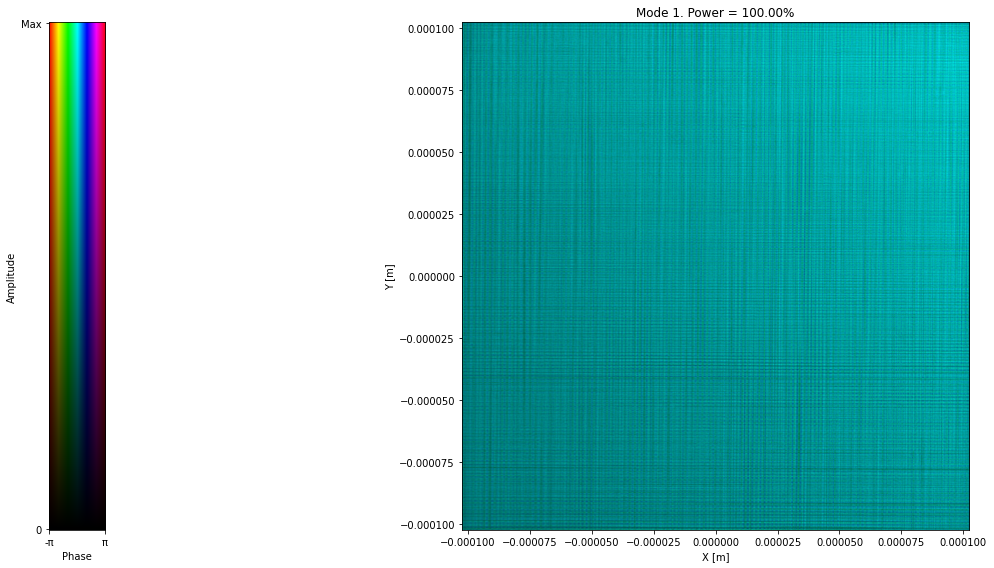

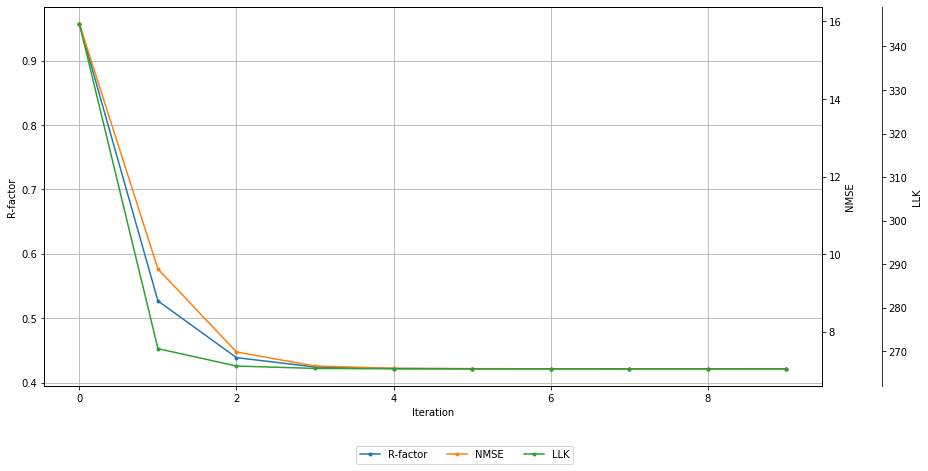

Saving output hdf5 file... 


ValueError: Unable to create group (name already exists)

In [24]:
obj_guess = np.ones(inputs["object_shape"])
probe_guess = np.expand_dims(np.ones_like(probe),axis=0)
inputs['regularization_object'] = 0.25
inputs['regularization_obj'] = 0.25
inputs['regularization_probe'] = 0.5
inputs['step_object'] = 0.5
inputs['step_probe'] = 1
inputs['use_mPIE'] = False
inputs['friction_object'] = 0.9
inputs['friction_probe'] = 0.99
inputs['momentum_counter'] = 10
inputs['distance_sample_focus']=0
inputs['probe_support_array'] = np.ones_like(probe)
inputs['free_log_likelihood'] = 0
inputs['regime'] = 'fresnel'
inputs['fourier_power_bound'] = 0
inputs['clip_object_magnitude'] = False


inputs['algorithms'] = {} # create a sub-dictionary to store the algorithms

inputs['CPUs'] = 32  # Number of CPUs to use in parallel execution

inputs['GPUs'] = [0]  # List of numbers (e.g. [0,1,2]) containing the number of the GPUs

inputs['hdf5_output'] = '/ibira/lnls/labs/tepui/home/yuri.tonin/output.h5'  # Path to hdf5 file to contain all outputs

inputs['regime'] = 'fresnel'  # Propagation regime. 'fraunhoffer' or 'fresnel'

inputs['object_padding'] = 200 # number of pixels to pad the object array. May be necessary if scan area is too large for the initial_object estimate

inputs['incoherent_modes'] = 1  # Number of incoherent modes to use

inputs['save_restored_data'] = False 

inputs['fourier_power_bound'] = 0.5  # relaxing the magnitude constraint on the Fourier domain. see equation S2 of Giewekemeyer et al. 10.1073/pnas.0905846107

inputs['distance_sample_focus'] = 0  # Distance in meters between sample and focus or pinhole, used to propagate the probe prior to application of the probe support

inputs['probe_support'] = {"type": "circular",  "radius": 100000,  "center_y": 0, "center_x": 0}  # Support to be applied to the probe matrix after probe update.
                                                                                                   # Options are: 
                                                                                                   # - {"type": "circular",  "radius": 300,  "center_y": 0, "center_x": 0} 
                                                                                                   # - {"type": "cross",  "center_width": 300,  "cross_width": 0, "border_padding": 0} 
                                                                                                   # - {"type": "array",  "data": myArray}

inputs["initial_obj"] = {"obj": 'random'}  # Initial guess for the object
                                               # Options are: 
                                               # - {"obj": my2darray}, numpy array 
                                               # - {"obj": 'path/to/numpyFile.npy'}, path to .npy, 
                                               # - {"obj": 'path/to/hdf5File.h5'}, path to .hdf5 of previous recon containing the reconstructed object in 'recon/object'
                                               # - {"obj": 'random'}, random matrix with values between 0 and 1
                                               # - {"obj": 'constant'}, constant matrix of 1s

inputs['initial_probe'] = { "probe": 'inverse'}  # Initial guess for the probe
                                                     # Options are: 
                                                     # - {"probe": my2darray}, numpy array 
                                                     # - {"probe": 'path/to/numpyFile.npy'}, path to .npy, 
                                                     # - {"probe": 'path/to/hdf5File.h5'}, path to .hdf5 of previous recon containing the reconstructed object in 'recon/object'
                                                     # - {"probe": 'random'}, random matrix with values between 0 and 1
                                                     # - {"probe": 'constant'}, constant matrix of 1s
                                                     # - {"probe": 'inverse'}, matrix of the Inverse Fourier Transform of the mean of DPs.
                                                     # - {"probe": 'circular', "radius": 100, "distance":0}, circular mask with a pixel of "radius". 
                                                     #   If a distance (in meters) is given, it propagates the round probe using the ASM method.
                                                     # - {"probe": 'fzp', 'beam_type': 'disc' or 'gaussian', 'distance_sample_fzpf': distance in meters, 
                                                     #   'fzp_diameter': diameter in meters, 'fzp_outer_zone_width': zone width in meters, 
                                                     #   'beamstopper_diameter': diameter in meters (0 if no beamstopper used), 'probe_diameter': diameter, 
                                                     #   'probe_normalize': boolean}


# inputs['algorithms']['1'] = {            # rPIE and mPIE engines. mPIE used if mPIE_friction_obj or mPIE_friction_probe > 0. 
#     'name': 'rPIE_python',
#     'iterations': 50,
#     'step_object': 0.5,                      # step size of object update function. 
#     'step_probe': 1,                         # step size of probe update function
#     'regularization_object': 0.25,           # rPIE regularization parameter. Should be between 0 and 1
#     'regularization_probe': 0.5,             # rPIE regularization parameter. Should be between 0 and 1
#     'momentum_obj': 0.9,                # if > 0, uses mPIE with the given friction value
#     'momentum_probe': 0.99,             # if > 0, uses mPIE with the given friction value
#     'mPIE_momentum_counter': 10,             # if == N, performs mPIE update every N iterations
# }  


inputs['algorithms']['1'] = {
    'name': 'RAAR_python',
    'iterations': 10,
    'beta': 0.9,                        # RAAR wavefront beta step
    'regularization_obj': 0.001,      # avoid division by zero in object update
    'regularization_probe': 0.001,       # avoid division by zero in probe update
}  

# inputs['algorithms']['3'] = {
#     'name': 'DM_python',
#     'iterations': 50,
#     'regularization_obj': 0.01,      # avoid division by zero in object update
#     'regularization_probe': 0.01,       # avoid division by zero in probe update
# }  

# inputs['algorithms']['4'] = {
#     'name': 'AP_python',
#     'iterations': 50,
#     'regularization_obj': 0.01,      # avoid division by zero in object update
#     'regularization_probe': 0.01,       # avoid division by zero in probe update
# }  


# inputs['algorithms']['5'] = { # Maximum Likelihood engine is in beta! Still under development.
#     'name': 'ML_python',
#     'iterations': 200,
#     'optimizer': 'gradient_descent',    # Options are: 'gradient_descent', 'conjugate_gradient' 
#     'step_object': 1e-8,                # usually requires small values!
#     'step_probe': 1e-8,                 # usually requires small values!
# }  


positions = np.roll(positions,1,axis=1)
obj, probe, corrected_positions, inputs, error = sscCdi.ptychography.call_ptychography(inputs, DPs, positions, initial_obj=obj_guess, initial_probe=probe_guess,plot=True)



Using CuPy (GPU)
Transfering data to GPU...
Object shape: (1, 2266, 2276)
Probe shape: (1, 2048, 2048)
Diffraction patterns shape: (16, 2048, 2048)
Wavefronts shape: (16, 1, 2048, 2048)
Positions shape: (16, 2)
	Iteration 10/10 	 Errors: R-factor=4.22e-01; MSE=7.05e+00; Poisson LLK=2.66e+02



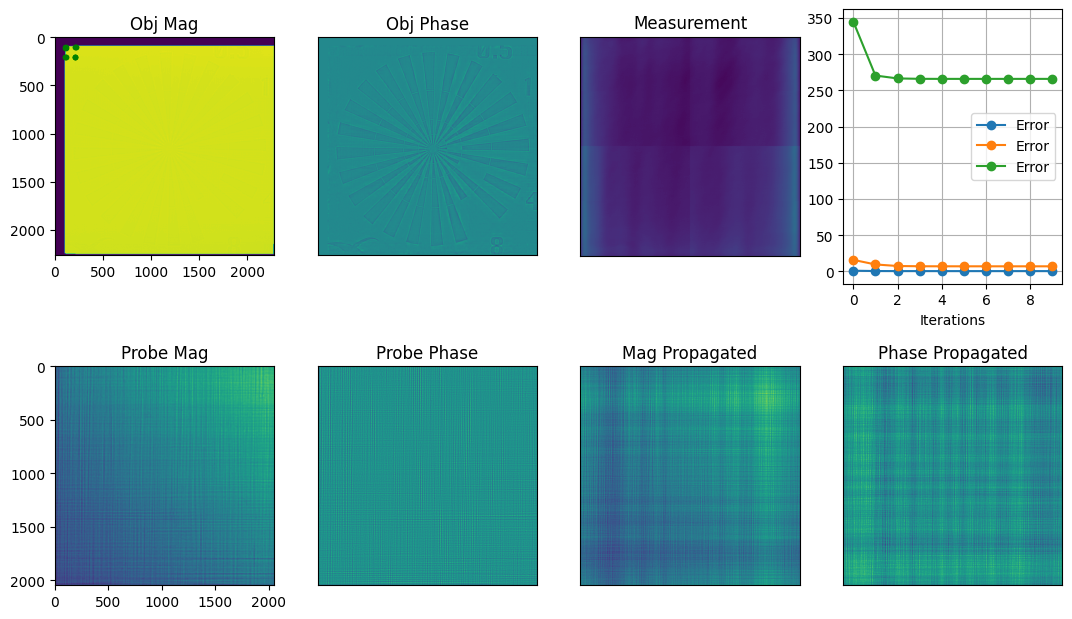

In [22]:
# positions = np.roll(positions,shift=1,axis=1)
RAAR_obj, RAAR_probes, RAAR_error = sscCdi.RAAR_python(DPs,positions,obj_guess,probe_guess[0],inputs)
# RAAR_obj, RAAR_probes, RAAR_error = sscCdi.ptycho.pie.PIE_multiprobe_loop(DPs,positions,obj_guess,probe_guess,inputs)

propagated_probe = sscCdi.fresnel_propagator_cone_beam(RAAR_probes[0],inputs["wavelength"],inputs["detector_pixel_size"],z2,z1) 
propagated_probe /= np.max(propagated_probe)

fig, ax = plt.subplots(2,4,figsize=(13,8),dpi=100)
ax[0,0].imshow(np.abs(RAAR_obj)), ax[0,0].set_title('Obj Mag')
# ax[0,0].plot(positions[:,1],positions[:,0],'.',color='r')
ax[0,0].plot(positions[:,0],positions[:,1],'.',color='g')
ax[0,1].imshow(np.angle(RAAR_obj)), ax[0,1].set_title('Obj Phase')
ax[0,2].imshow(np.abs(empty)), ax[0,2].set_title('Measurement')
ax[1,0].imshow(np.abs(RAAR_probes[0])), ax[1,0].set_title('Probe Mag')
ax[1,1].imshow(np.angle(RAAR_probes[0])), ax[1,1].set_title('Probe Phase')
ax[1,2].imshow(np.abs(propagated_probe)), ax[1,2].set_title('Mag Propagated')
ax[1,3].imshow(np.angle(propagated_probe)), ax[1,3].set_title('Phase Propagated')
ax[0,3].plot(RAAR_error,'o-',label='Error')
ax[0,3].set_xlabel('Iterations')
ax[0,3].legend(), ax[0,3].grid()

# fig.suptitle('Near Field Ptychography')

for i, ax in enumerate(ax.ravel()):
    if i==3 or i==0 or i ==4: continue
    ax.set_xticks([])
    ax.set_yticks([])